# Airbnb Public Dataset 

### Using R to Measure the Financial Performance of each Listing

**This dataset contains *16 features* about Airbnb listings within New York City. Below are the features with their respective descriptions**:

* **id** - Listing ID
* **name** - Listing Title
* **host_id** - ID of Host
* **host_name** - Name of Host
* **neighbourhood_group** - Borough that contains listing 
* **neighbourhood** - Name of neighbourhood that listing is in
* **latitude** - latitude of listing
* **longitude** - longitude of listing
* **room_type** - Type of public space that is being offered
* **price** - price per night, USD
* **minimum_nights** - minimum number of nights required to book listing
* **number_of_reviews** - total number of reviews that listing has accumulated 
* **last_review** - date in which listing was last rented
* **reviews_per_month** - total number of reviews divided by the number of months the listing is active
* **calculated_host_listings_count** - amount of listing per host****
* **availability_365** - number of days per year the listing is active

### PROBLEM DEFINITION:

Before we start writing any code, let's take a look and digest each variable. Where could we see potential interactions? Where could potential problems lie?

how can this be leveraged to support a future Airbnb host? 
***  
  
  
***number_of_reviews***

If we wanted to measure the **total volume** of stays, this would be a nice **KPI** to examine.   
   
   ***

***price***

Those that can *sell* their listing at a higher price, will be more profitable (in theory). Another nice **KPI** to declare.  
   
   ***
  
***minimum_nights***   

If those can *sell* their listing with a higher amount of minimum nights, a tenant will have to pay a higher price. Our last **KPI**.  

   ***
   
With these 3 KPIs, I am going to declare a function of the 3 - our response variable: 
   
   ***

**total_net_revenue** = [number_of_reviews] x [price (USD)] x [minimum_nights]

   
   ***
Now again, business rules have been assumed...

Someone that books a listing may not leave a review, although I would imagine most tenants leave a review after staying; as an Airbnb customer myself - hosts recommend you to leave a review.

The number of reviews represent how many customers the listing has experienced, the price per night is self-explanatory, and minimum nights give a baseline cost of the stay based on price * minimum_nights.


In [3]:
## Importing packages

# This R environment comes with all of CRAN and many other helpful packages preinstalled.
# You can see which packages are installed by checking out the kaggle/rstats docker image: 
# https://github.com/kaggle/docker-rstats

library(tidyverse) # metapackage with lots of helpful functions
library(NLP)
library(tm)
library(wordcloud)
library(ggplot2)
library(plotly)
library(tidytext)
library(tidyr)
library(lubridate)
library(MASS)
library(caret)



## Running code

# In a notebook, you can run a single code cell by clicking in the cell and then hitting 
# the blue arrow to the left, or by clicking in the cell and pressing Shift+Enter. In a script, 
# you can run code by highlighting the code you want to run and then clicking the blue arrow
# at the bottom of this window.

## Reading in files

# You can access files from datasets you've added to this kernel in the "../input/" directory.
# You can see the files added to this kernel by running the code below. 


ab <- read.csv("AB_NYC_2019.csv")


## Saving data

# If you save any files or images, these will be put in the "output" directory. You 
# can see the output directory by committing and running your kernel (using the 
# Commit & Run button) and then checking out the compiled version of your kernel.

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.2     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘NLP’


The following object is masked from ‘package:ggplot2’:

    annotate


Loading required package: RColorBrewer


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘MASS’


The following object is masked from ‘package:plotly’:

    select


The followi

### Exploratory Data Analysis

Let's take a look at all of our variables with a careful approach. I will declare a couple of conditional variables to kick things off. 
   
Secondly, for our **NLP** component - I will examine and dissect the Listing Names to measure effectiveness of the title used.

The values below are the quantiles of our variables.

I also provided a header to display our new variables.

In [4]:
#Declaring Categorical Variables using our response variable parameters

p = integer(10)
r = integer(10)


for (i in 1:10) {
     
     p[i] = quantile(ab$price,i * 0.1) 
     r[i] = quantile(ab$number_of_reviews,i * 0.1)
}

p
r

#Grouping our categorical variable by 20th Percentile Quantiles

ab <- ab %>% mutate(price_group=ifelse(price < 61, "Very Low",
                                           ifelse(price < 91, "Low",
                                                  ifelse(price < 131, "Moderate",
                                                         ifelse(price < 201, "High", "Very High"
                                                               )))))


ab <- ab %>% mutate(usage_group=ifelse(number_of_reviews < 1, "None",
                                         ifelse(number_of_reviews < 4, "Low",
                                                ifelse(number_of_reviews < 10, "Moderate",
                                                        ifelse(number_of_reviews < 34, "High", "Very High"
                                                        )))))

#Declaring our Response Variable

ab <- ab %>% mutate(total_net_revenue = price * number_of_reviews * minimum_nights)

#Displaying our new variables

head(ab[,17:19])



[1]    49    60    75    90   106   130   155   200   269 10000

[1]   0   0   1   3   5   9  17  33  70 629

,price_group,usage_group,total_net_revenue
,<chr>,<chr>,<int>
1,High,Moderate,1341
2,Very High,Very High,10125
3,High,None,0
4,Low,Very High,24030
5,Low,Moderate,7200
6,High,Very High,44400


Here is the data prep / cleansing code for our NLP analysis; this is specifically looking at a single gram:

In [5]:
#NLP Code

#Partitioning by Price Type

ab_vhp = subset(ab, price_group == "Very High")
ab_vlp = subset(ab, price_group == "Very Low")

length(ab_vhp$price_group)
length(ab_vlp$price_group)

#Storing into Corpus Format

dfa <- data.frame(doc_id = 1:48895, text = ab$name, stringsAsFactors = FALSE)
df_corpusa <- Corpus(DataframeSource(dfa))

dfh <- data.frame(doc_id = 1:8384, text = ab_vhp$name, stringsAsFactors = FALSE)
df_corpush <- Corpus(DataframeSource(dfh))

dfl <- data.frame(doc_id = 1:10063, text = ab_vlp$name, stringsAsFactors = FALSE)
df_corpusl <- Corpus(DataframeSource(dfl))

#Token Cleansing

df_corpush <- tm_map(df_corpush, removePunctuation)
df_corpusl <- tm_map(df_corpusl, removePunctuation)
df_corpusa <- tm_map(df_corpusa, removePunctuation)
df_corpush <- tm_map(df_corpush, tolower)
df_corpusl <- tm_map(df_corpusl, tolower)
df_corpusa <- tm_map(df_corpusa, tolower)
df_corpush <- tm_map(df_corpush, removeNumbers)
df_corpusl <- tm_map(df_corpusl, removeNumbers)
df_corpusa <- tm_map(df_corpusa, removeNumbers)
df_corpush <- tm_map(df_corpush, removeWords, stopwords("english"))
df_corpusl <- tm_map(df_corpusl, removeWords, stopwords("english"))
df_corpusa <- tm_map(df_corpusl, removeWords, stopwords("english"))


dtmh <-DocumentTermMatrix(df_corpush,control = list(weighting = function(x) weightTfIdf(x, normalize = FALSE)))
dtml <-DocumentTermMatrix(df_corpusl,control = list(weighting = function(x) weightTfIdf(x, normalize = FALSE)))
dtma <-DocumentTermMatrix(df_corpusa,control = list(weighting = function(x) weightTfIdf(x, normalize = FALSE)))

freqh <- sort(colSums(as.matrix(dtmh)), decreasing=TRUE)
freql <- sort(colSums(as.matrix(dtml)), decreasing=TRUE)
freqa <- sort(colSums(as.matrix(dtma)), decreasing=TRUE) 

wfh <- data.frame(word=names(freqh), freq=freqh) 
wfl <- data.frame(word=names(freql), freq=freql)
wf <- data.frame(word=names(freqa), freq=freqa)

set.seed(1)   

dark2 <- brewer.pal(6, "Dark2")



[1] 8384

[1] 10063



Let's conduct some Data Viz. 
   
   
Firstly, I will ensure our categorical variables are stored dynamically as factors . Secondly, I grouped out our price variable categorically, because I think the "How much does it cost to stay there?" question arises pretty frequently in NYC.

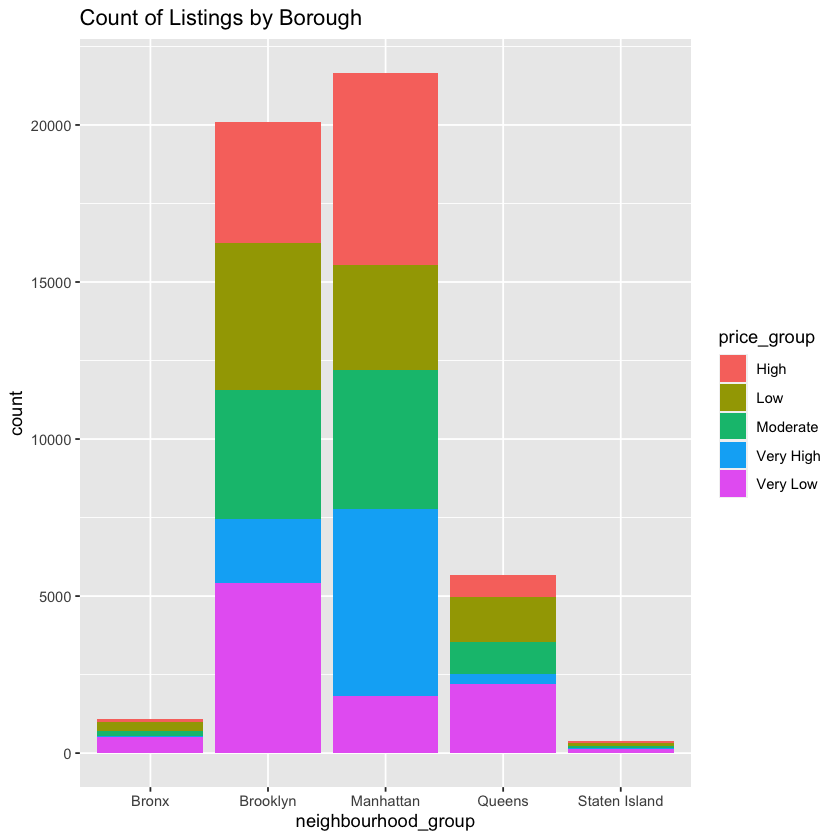

In [6]:
ggplot(ab, aes(neighbourhood_group)) + geom_bar(aes(fill = price_group)) + ggtitle("Count of Listings by Borough")

  
    
*     **Manhattan** contains the most amount of listings; additionally, it looks like it is the most expensive. 
    
*     Next,**Brooklyn** appears to be next popular; however,with a more reasonable distribution of price listings. **High - Very High** seem to only take up *20%* of the population.

*     Queens has only **5000** listings, and appears very cheap.

*     Lastly, the Bronx & State Island do not appear very popular for Airbnb.

Here we can see the density of listings by borough.

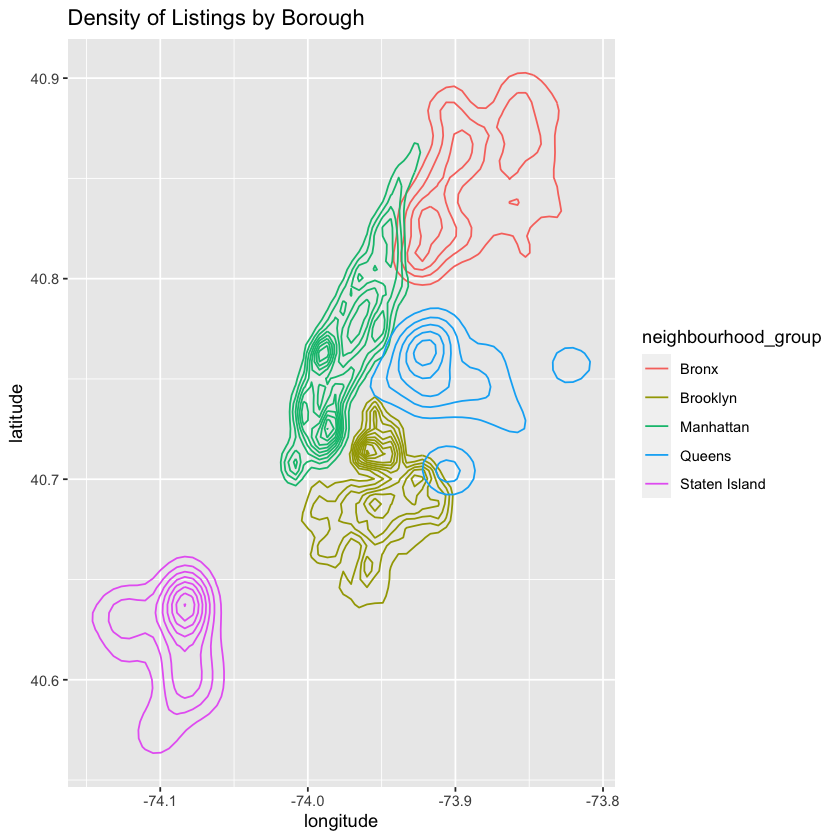

In [7]:
p_latlon <-ggplot(ab, aes(longitude,latitude)) + geom_density2d(aes(color = neighbourhood_group)) + ggtitle("Density of Listings by Borough")
p_latlon




In the interest of aesthetics, I will only choose 2 price groupings. Below shows the location density of our 2 pricing groups:

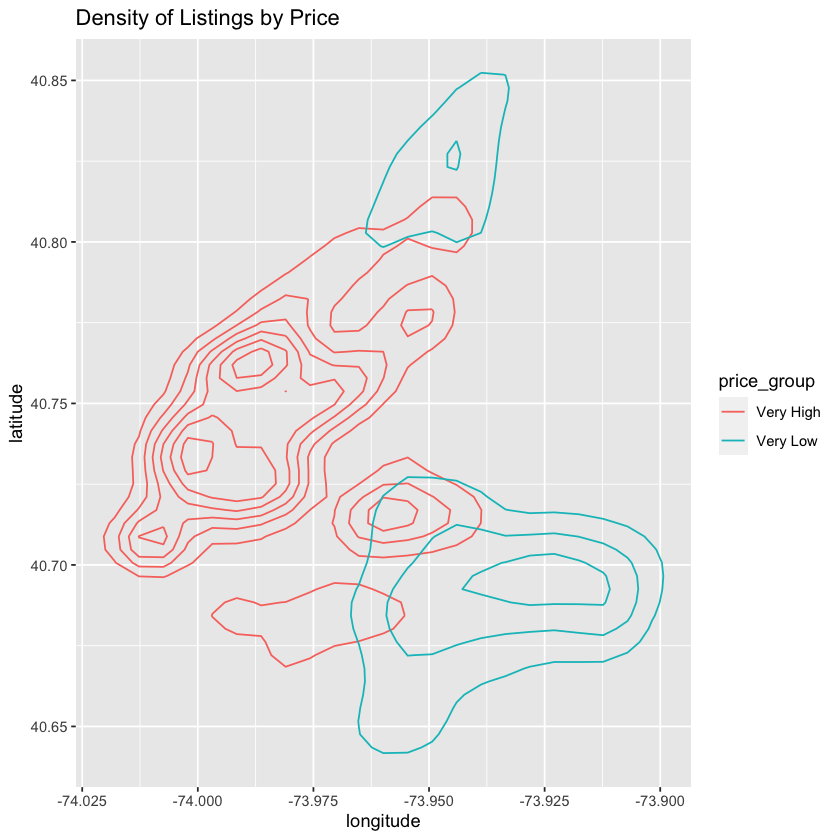

In [8]:
p_price <-ggplot(subset(ab, price_group == "Very High" | price_group == "Very Low"), aes(longitude,latitude)) + geom_density2d(aes(color = price_group)) + ggtitle("Density of Listings by Price")
p_price

Let's use a GIS concept and check an area of land to see which neighborhood's we're seeing in the pricey region (I'm guessing it's Manhattan):

In [9]:
summary(subset(ab, latitude > 40.7 & latitude < 40.76 & longitude < -73.98 & longitude > -74.02)$neighbourhood_group)

   Length     Class      Mode 
     8811 character character 

Yup!
   
OK - let's take a look at the **room type** feature.

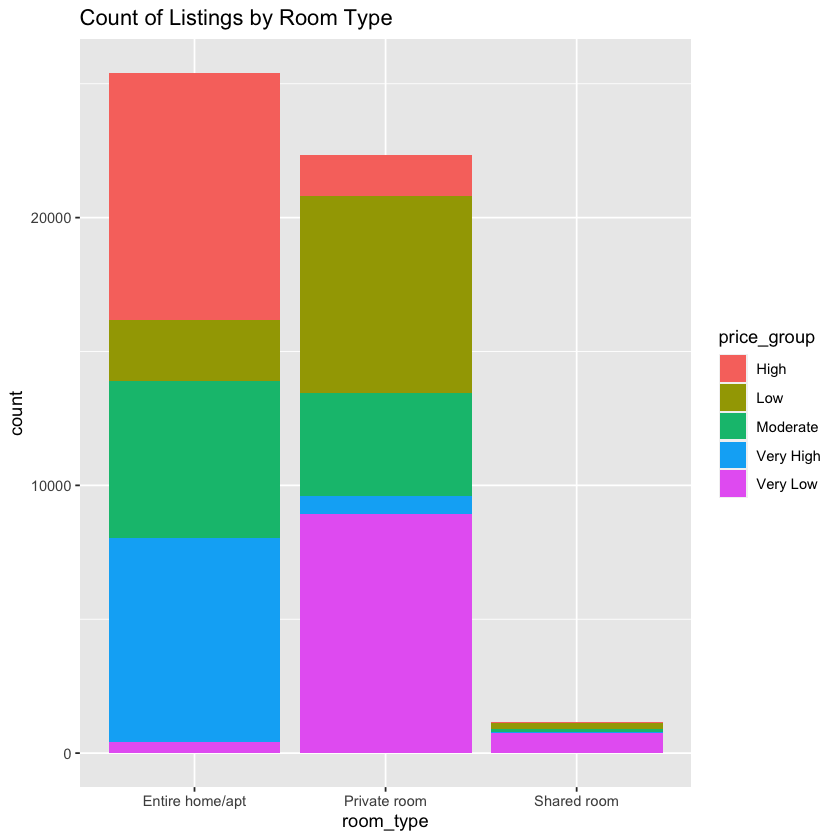

In [10]:
ggplot(ab, aes(room_type)) + geom_bar(aes(fill = price_group)) + ggtitle("Count of Listings by Room Type")

No surprise here. Let's move on!   

   
   I wanted to examine the difference we see in word choice within titles, specifically between cheap and pricey Airbnbs.

Below is a *wordcloud* of **High Price** Airbnb's Listing Titles:

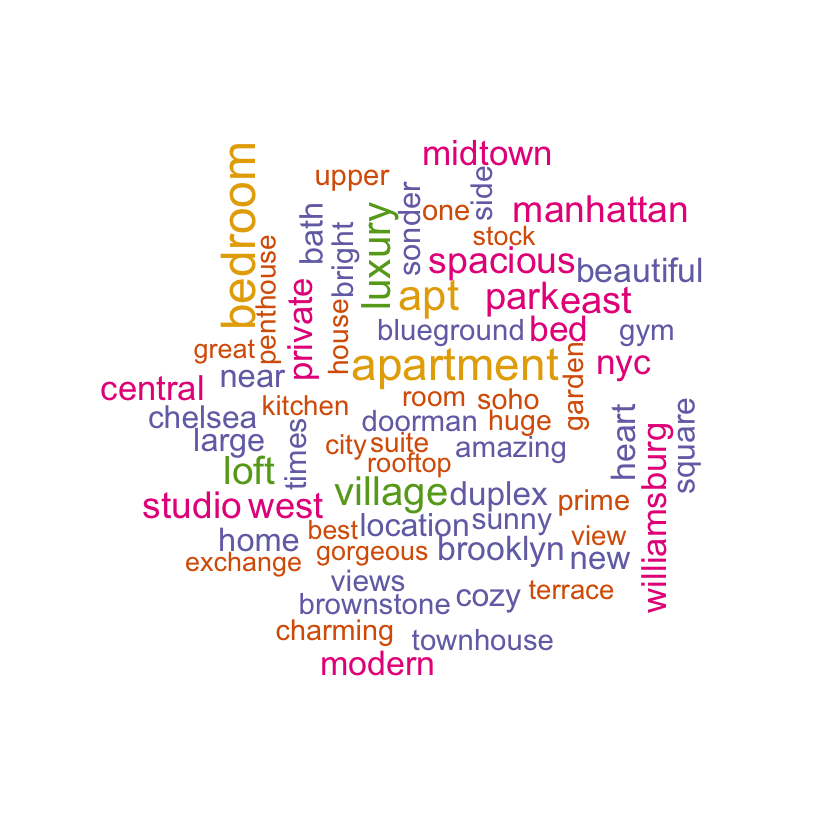

In [11]:
wordcloud(names(freqh), freqh, min.freq = 825, max.words=100, rot.per=0.2, colors=dark2,scale=c(2.4,1))



**Luxury, Loft, and Village** pop out at me.

Below is a wordcloud of **Low Price** Airbnb's Listing Titles:

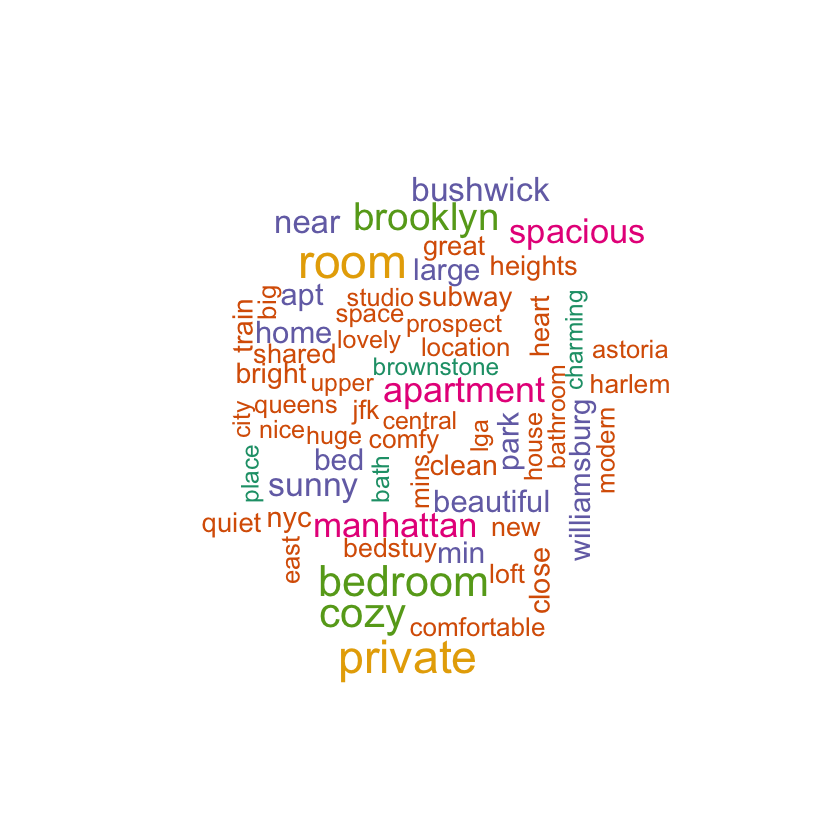

In [12]:
wordcloud(names(freql), freql, min.freq = 825, max.words=100, rot.per=0.2, colors=dark2,scale=c(2.4,1))

**Cozy, bedroom, and private** pop out at me here.

In [13]:
#Using tidytext packages to break down our titles into sorted bigrams, while removing stopwords such as "the" & "and"

names <- ab %>%
 unnest_tokens(bigram, name, token = "ngrams", n = 2)
 
 
 bigrams_separated <- names %>%
     separate(bigram, c("word1", "word2"), sep = " ")
 
 bigrams_filtered <- bigrams_separated %>%
     filter(!word1 %in% stop_words$word) %>%
     filter(!word2 %in% stop_words$word)
 
 bigram_counts <- bigrams_filtered %>% 
     count(word1, word2, sort = TRUE)
 

I am now going to use NLP to break out the **Titles of the Listings** into n-grams. In this example, I will use grams and bigrams.   
   
   What I will be doing, is merging the **top 20** most frequently used **bigrams**, and the **top 40** most frequently used grams to our dataset.
   
   This way, we can measure the relationship of title language on our net revenue. Thus, allowing hosts to phrase their listing in the best way possible, in hopes to maximize profits!
      

Below is a tibble of the** top 6 **bigrams used in our dataset's listing titles:

In [14]:
#Top 6 most used bigrams

df_big <- as.data.frame(bigram_counts)
df_big <- df_big %>% mutate(both = paste(df_big$word1, df_big$word2, sep = " "))
head(df_big)

,word1,word2,n,both
,<chr>,<chr>,<int>,<chr>
1,1,bedroom,1797,1 bedroom
2,central,park,1355,central park
3,east,village,1321,east village
4,2,bedroom,1156,2 bedroom
5,private,bedroom,963,private bedroom
6,bedroom,apartment,890,bedroom apartment


In [15]:
#These loops count the number of times our top 20 used bigrams appear in each title, and then insert them into our dataset under its own feature; so we're adding 20 additional columns



for (i in 1:20){
     
     x = integer(48895)
     x = data.frame(x)
     colnames(x)[1]=as.character(df_big[i,4])
     ab=cbind(ab, x)
 }

dim(ab)


for (i in 1:48895) {
     
     df = data.frame(doc_id = 1, text = ab$name[i])
     names_temp <- df %>%
     unnest_tokens(bigram, text, token = "ngrams", n = 2)
 
     bigrams_separated_temp <- names_temp %>%
     separate(bigram, c("word1", "word2"), sep = " ")
 
     bigrams_filtered_temp <- bigrams_separated_temp %>%
     filter(!word1 %in% stop_words$word) %>%
     filter(!word2 %in% stop_words$word)
 
     bigram_counts_temp <- bigrams_filtered_temp %>% 
     count(word1, word2, sort = TRUE)
     
     df_big_temp <- as.data.frame(bigram_counts_temp)
     df_big_temp <- df_big_temp %>% mutate(both = paste(df_big_temp$word1, df_big_temp$word2, sep = " "))
     
    
         for (j in 1:20) {
     
         str = as.character(colnames(ab)[j+19])
     
             if (str %in% df_big_temp[,4]) {
                 ab[i,j+19] = df_big_temp[str,3] 
             }
             else {
             ab[i,j+19]= 0
         
     
         }
     }
}



[1] 48895    39

Below is how our new dataset is structured!  
  
  Notice how the **central park** feature has a 1 under *observation 5*.

In [16]:
#Checking most frequently used bigram

summary(ab[,20])

#Oops - well I think we can safely assume there is only 1 unique bigram per title

for (i in 1:20) {

ab[is.na(ab[,19 + i]),19 + i] <- 1
    
    }
head(ab[,c(1:2,17:28)])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0       0       0       0       0       0    1796 

,id,name,price_group,usage_group,total_net_revenue,1 bedroom,central park,east village,2 bedroom,private bedroom,bedroom apartment,upper east,times square,west village
,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2539,Clean & quiet apt home by the park,High,Moderate,1341,0,0,0,0,0,0,0,0,0
2,2595,Skylit Midtown Castle,Very High,Very High,10125,0,0,0,0,0,0,0,0,0
3,3647,THE VILLAGE OF HARLEM....NEW YORK !,High,None,0,0,0,0,0,0,0,0,0,0
4,3831,Cozy Entire Floor of Brownstone,Low,Very High,24030,0,0,0,0,0,0,0,0,0
5,5022,Entire Apt: Spacious Studio/Loft by central park,Low,Moderate,7200,0,1,0,0,0,0,0,0,0
6,5099,Large Cozy 1 BR Apartment In Midtown East,High,Very High,44400,0,0,0,0,0,0,0,0,0


I will now conduct the same algorithm, but merge our **40 most frequently used grams**.   
  
  Our dataset is now at **39 features**, and will grow to **80 features** as I will additionally add *length of title* as a variable along with each gram.

In [ ]:
#These loops count the number of times our top 40 used grams appear in each title, a title length, and then insert them into our dataset under its own feature; so we're adding 41 additional columns

for (i in 1:40){
     
     x = integer(48895)
     x = data.frame(x)
     colnames(x)[1]=as.character(wf[i,1])
     ab=cbind(ab, x)
 }

leng = integer(48895)
leng = data.frame(leng)
colnames(leng)[1]="length"
ab = cbind(ab, leng)


for (i in 1:48895) {
     
     df = data.frame(doc_id = 1, text = ab$name[i])
     docs = Corpus(DataframeSource(df))
     docs = tm_map(docs, removePunctuation)
     docs = tm_map(docs, tolower)
     docs = tm_map(docs, removeNumbers)
     docs = tm_map(docs, removeWords, stopwords("english"))
     dtm = DocumentTermMatrix(docs)
     freq <- sort(colSums(as.matrix(dtm)), decreasing=TRUE)
     wf <- data.frame(word=names(freq), freq=freq)
     
     for (j in 1:40) {
     
     str = colnames(ab)[j+39]
     
     if (str %in% wf[,1]) {
         ab[i,j+39] = wf[str,2] 
     }
     else {
         ab[i,j+39]= 0
         
     
     }
     ab[i, 80] = length(wf$word)    
         
 }}


Let's now ensure it populated the right fields!

In [18]:
summary(ab[,41])
summary(ab[,80])
head(ab[,c(1:2,39:45,80)])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1464  0.0000  2.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   4.000   5.000   4.544   5.000  18.000 

,id,name,private bathroom,room,private,bedroom,cozy,brooklyn,apartment,length
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,2539,Clean & quiet apt home by the park,0,0,0,0,0,0,0,5
2,2595,Skylit Midtown Castle,0,0,0,0,0,0,0,3
3,3647,THE VILLAGE OF HARLEM....NEW YORK !,0,0,0,0,0,0,0,3
4,3831,Cozy Entire Floor of Brownstone,0,0,0,0,1,0,0,4
5,5022,Entire Apt: Spacious Studio/Loft by central park,0,0,0,0,0,0,0,6
6,5099,Large Cozy 1 BR Apartment In Midtown East,0,0,0,0,1,0,1,5


Before I finish our text mining / cleansing, I wanted to ensure we're not **double counting grams** after we've counted a word in a bigram. I will use *conditional logic* to subtract any double counts.

In [19]:
for (k in 1:48895){
 
 
 for (i in 1:40) {
     
     for (j in 1:20) {
         
     
     
     if (grepl(colnames(ab)[39+i], colnames(ab)[j+19],fixed=TRUE) == TRUE) {
         
         if (ab[k, 39 + i] > 0) {
             
             ab[k, 39+i] = ab[k, 39+i] - ab[k, j+19]
                
         }
         
     }
       
     }
     
 }
     
 }

In [20]:
#Checking that it reduced the mean 
summary(ab[,41])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1136  0.0000  2.0000 

Now that we've finished our NLP leg work, let's move onto continuous variable visualization:

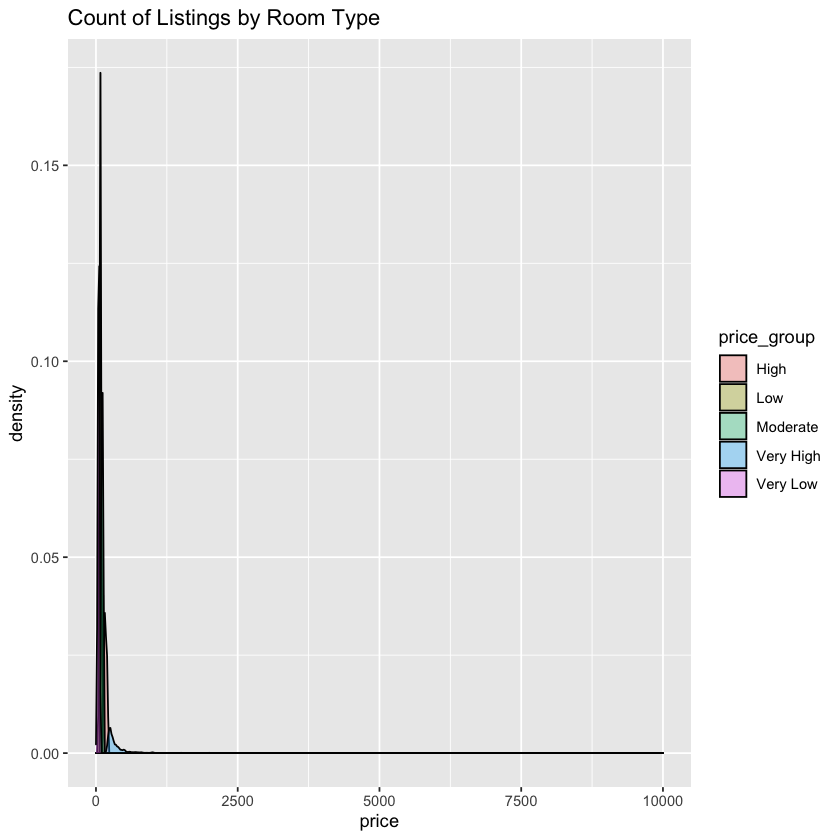

In [21]:
ggplot(ab, aes(price)) + geom_density(aes(fill = price_group), alpha=0.35) + ggtitle("Count of Listings by Room Type")

Not very meaningful - it looks like we have a LARGE right skew... those darn Manhattan penthouses. Let's take a closer look and ignore everything above $500.

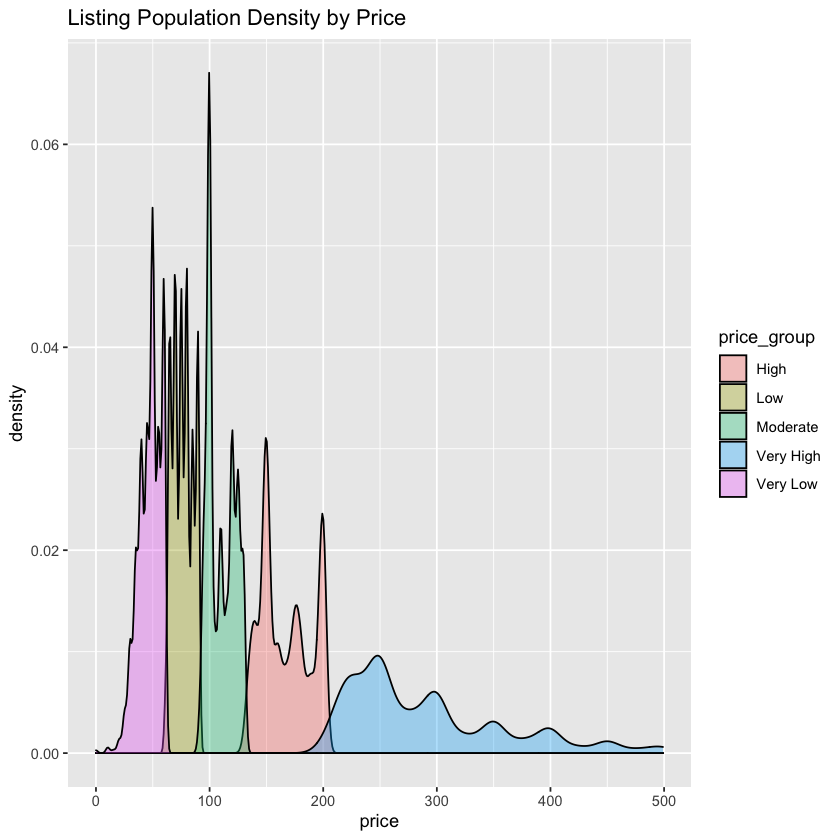

In [22]:
ggplot(subset(ab, price < 500), aes(price)) + geom_density(aes(fill = price_group), alpha=0.35) + ggtitle("Listing Population Density by Price")

This distribution may actually be homoscedastic if it weren't for the tail end 20% quantile. I'm sure we could assume a normal distribution with a log transformation and removing the high leverage points.   
   
   However, our response variable is not price, but net revenue. Let's continue!

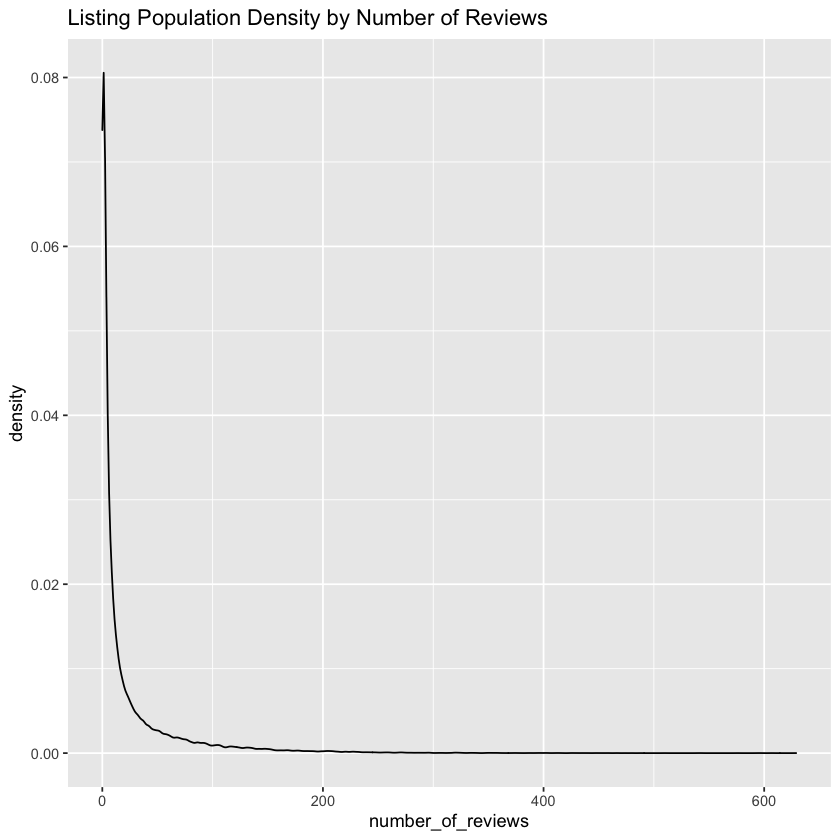

In [23]:
ggplot(ab, aes(number_of_reviews)) + geom_density() + ggtitle("Listing Population Density by Number of Reviews")

Again, a very large right skew.  It also looks like 8% of our population has **0 reviews**. We will want to remove these from our calculated response variable.   
   
   Lastly, let's take a look at minimum nights:

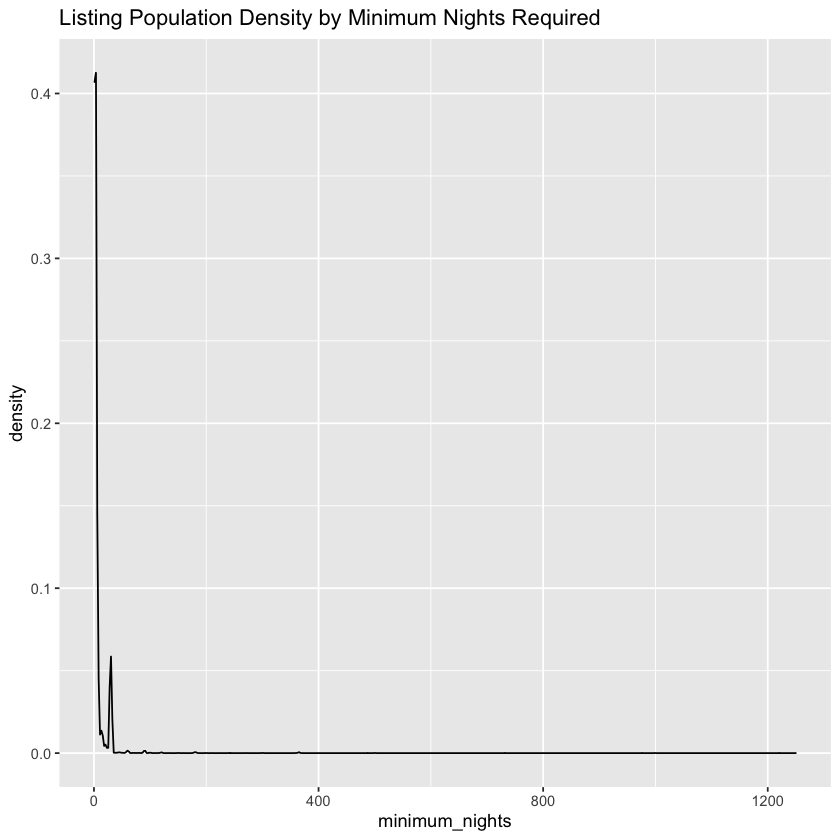

In [24]:
ggplot(ab, aes(minimum_nights)) + geom_density() + ggtitle("Listing Population Density by Minimum Nights Required")

This again!

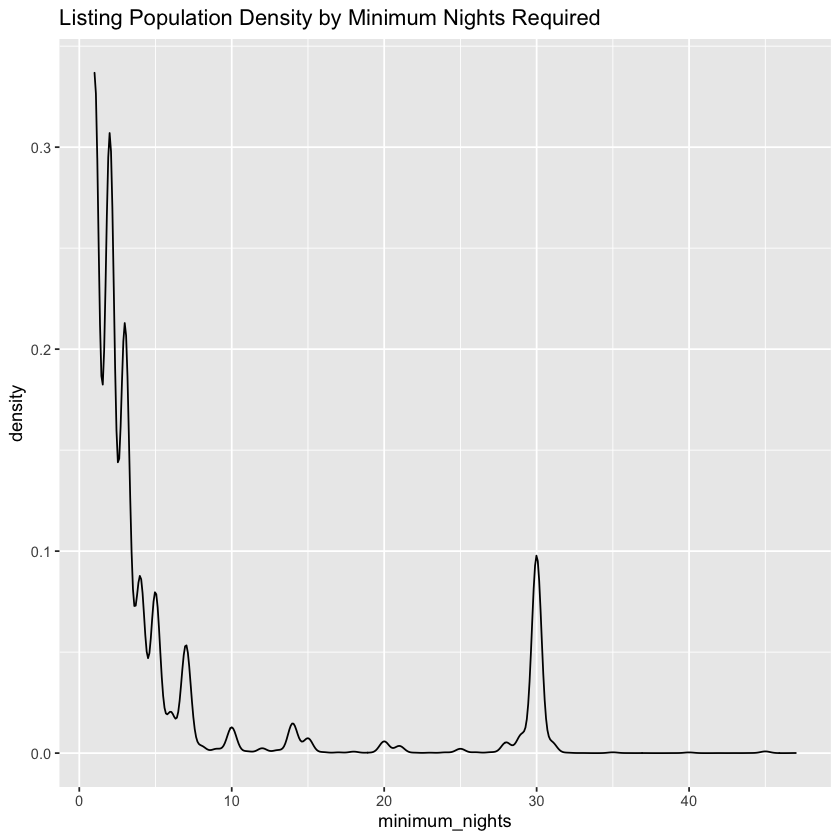

In [25]:
ggplot(subset(ab, minimum_nights < 50), aes(minimum_nights)) + geom_density() + ggtitle("Listing Population Density by Minimum Nights Required")

This makes sense, as a majority of our listings are setting the minimum nights required under 10 nights.

Lastly, let's take a look at our **response variable:   **
   
   Let's first declare a new dataset removing all of our unused listings.

In [26]:
abg <- subset(ab, total_net_revenue > 0)

summary(abg$total_net_revenue)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
      20      875     3240    16741    11340 11166804 

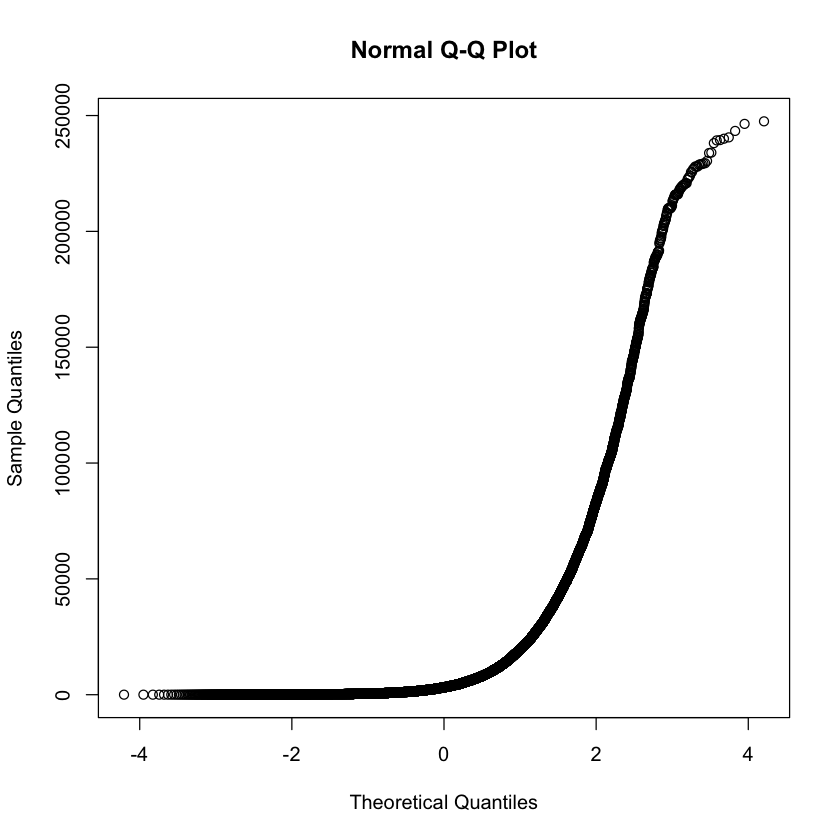

In [27]:
#Removing Outliers

abg <- subset(abg, total_net_revenue < 250000)
qqnorm(abg$total_net_revenue)

*Using log transformation:*

[1] 38575

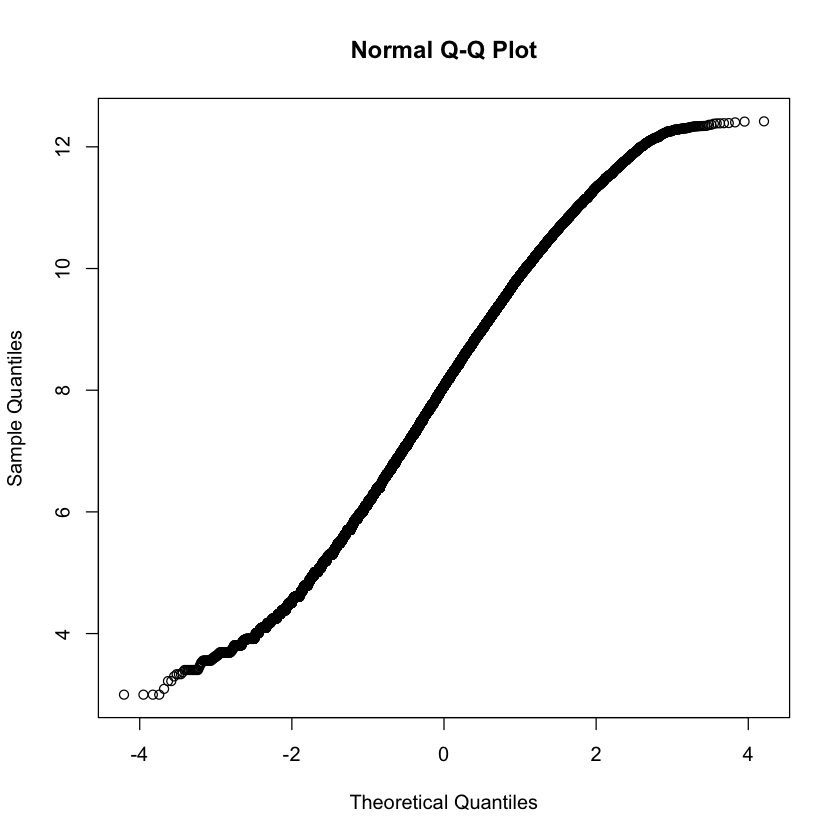

In [28]:
qqnorm(log(abg$total_net_revenue))
length(abg$total_net_revenue)

Much better! Our dataset has now been reduced from 49k observations to 38.6k, and our response variable has been transformed to a somewhat normal looking distribution.





I want to examine one more section of Data Viz - going a little more advanced. I would like to see if there are any noticeable effects of **word counts, location, and our response variable**.   
   
   I will start with a bigram first -   
   ### private bathroom


   
    Bronx Brooklyn Manhattan Queens Staten Island
  0   871    16188     16389   4527           310
  1     4      160        84     38             4

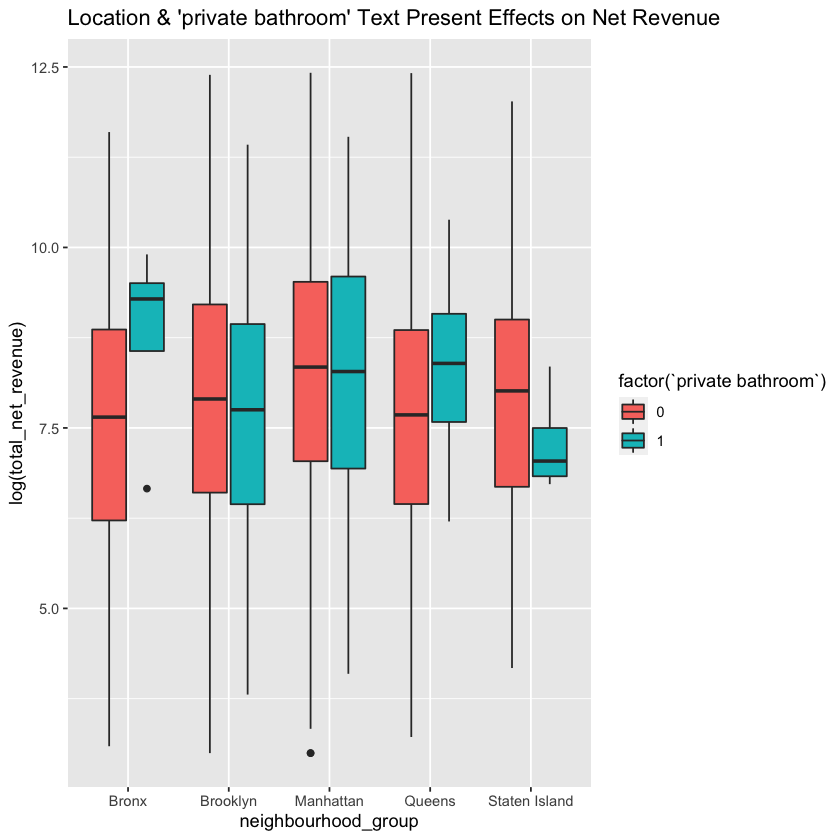

In [29]:
table(factor(abg$`private bathroom`),abg$neighbourhood_group)
p_rev_w1 <- ggplot(abg, aes(neighbourhood_group, log(total_net_revenue))) + geom_boxplot(aes(fill = factor(`private bathroom`))) + ggtitle("Location & 'private bathroom' Text Present Effects on Net Revenue")
p_rev_w1



Now with one word -   
   ### cozy

   
    Bronx Brooklyn Manhattan Queens Staten Island
  0   790    14816     14882   3994           276
  1    85     1531      1591    570            38
  2     0        1         0      0             0
  3     0        0         0      1             0

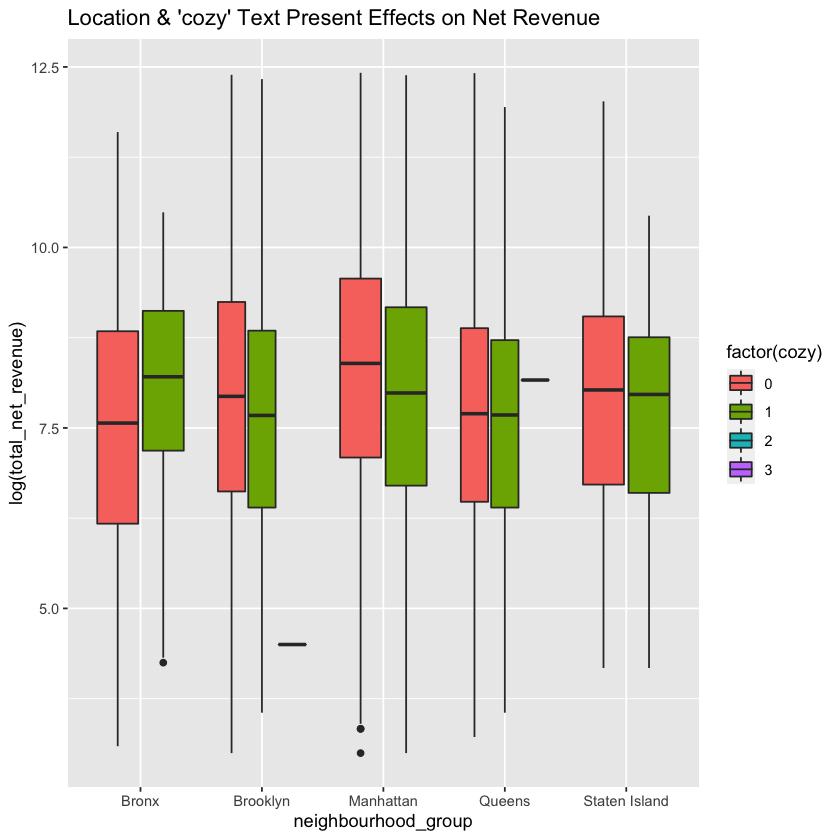

In [30]:
table(factor(abg$cozy),abg$neighbourhood_group)
p_rev_w2 <- ggplot(abg, aes(neighbourhood_group, log(total_net_revenue))) + geom_boxplot(aes(fill = factor(cozy))) + ggtitle("Location & 'cozy' Text Present Effects on Net Revenue")
p_rev_w2

Interesting...

* These plots suggest that in **Queens** (discrediting the Bronx distribution due to sample size), those that list a title with the words *'private bathroom'* appear to bring in a **higher Net Revenue**.
   
* It also suggests that in the **Bronx**, those that list a title with the word *'cozy'* appear to bring in a **higher Net Revenue**; while in **Manhattan**, listings with *'cozy'* are not performing as well.   
     * Perhaps those that are staying in **Manhattan** don't want a 'cozy' spot - but a luxurious 'loft'... let's check!


### loft
  

   
    Bronx Brooklyn Manhattan Queens Staten Island
  0   863    15338     15920   4528           307
  1    12     1006       552     36             7
  2     0        4         1      1             0

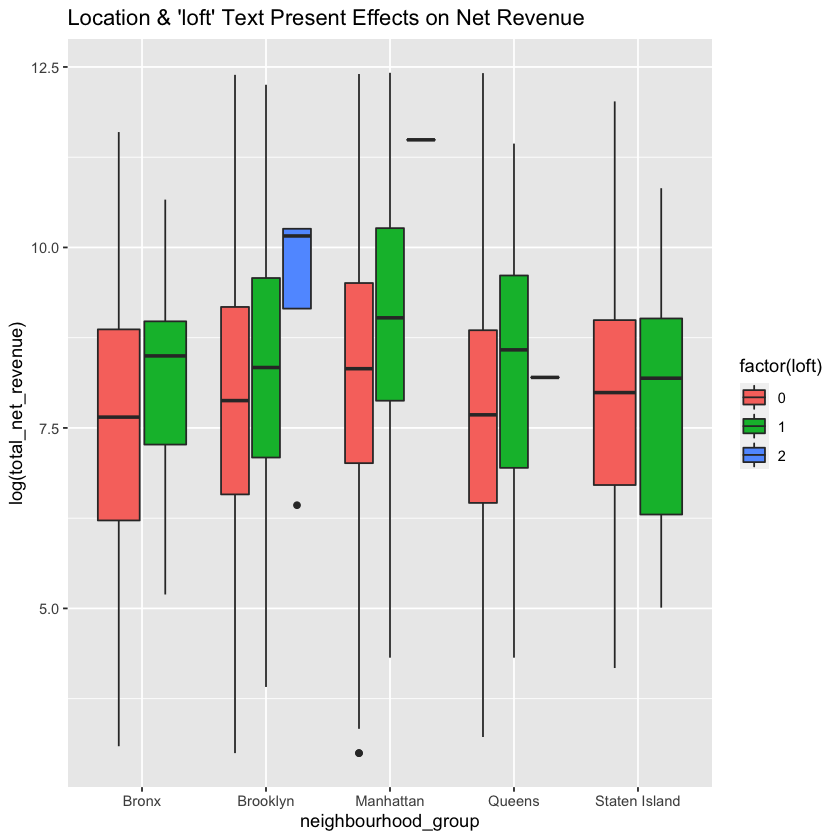

In [31]:
table(factor(abg$loft),abg$neighbourhood_group)
p_rev_w3 <- ggplot(abg, aes(neighbourhood_group, log(total_net_revenue))) + geom_boxplot(aes(fill = factor(loft))) + ggtitle("Location & 'loft' Text Present Effects on Net Revenue")
p_rev_w3

**BINGO**!

*Note - if I ever lease a place on Airbnb in Manhattan or Brooklyn, remind me to put 'loft' in the title!*

 

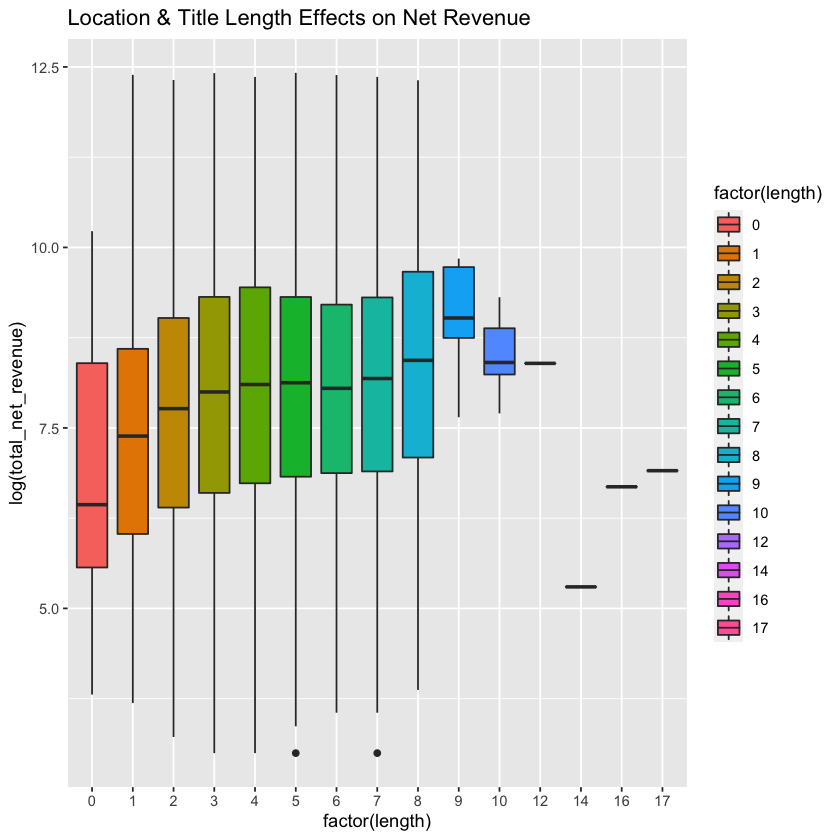

In [32]:
p_rev_w4 <- ggplot(abg, aes(factor(length),log(total_net_revenue))) + geom_boxplot(aes(fill = factor(length))) + ggtitle("Location & Title Length Effects on Net Revenue")
p_rev_w4

When Listing your Airbnb, make sure it contains at least **4 meaningful words!**   
   
   
These are just 4 plots - I'm sure we can find a lot more deltas!

### Predictive Modeling

I will now dive into some predictive modeling. Let's focus on 2 boroughs solely, so we can have a finer scope in reporting.

I will start with **Brooklyn**.

Let's take a step back and remember what our problem definition is. We want to maximize our net revenue as a lister. Therefore, we want to model net revenue.

We can control a lot of things such as the listing title, where our property is located, what kind of property we're leasing, the price range, and the availability. We cannot control our **KPI**.




In [33]:
#Removing non-feasible features and features that we used to calculate our response variable

abg_p = abg[,-c(1,2,3,4,6,10,11,12,13,14,18)]

#Partitioning by neighbourhood

abg_m = subset(abg_p, neighbourhood_group == "Manhattan")
abg_bn = subset(abg_p, neighbourhood_group == "Brooklyn")
abg_bx = subset(abg_p, neighbourhood_group == "Bronx")
abg_q = subset(abg_p, neighbourhood_group == "Queens")

abg_m = abg_m[,-1]
abg_bn = abg_bn[,-1]
abg_bx = abg_bx[,-1]
abg_q = abg_q[,-1]

#Locating features with no / trivial counts of a bigram / gram within the title

x_m = integer(60)
x_bn = integer(60)
x_bx = integer(60)
x_q = integer(60)



for (i in 1:60) {
    
    x_m[i] = sum(abg_m[,8+i]) / length(abg_m[,1])
    x_bn[i] = sum(abg_bn[,8+i]) / length(abg_bn[,1])
    x_bx[i] = sum(abg_bx[,8+i]) / length(abg_bx[,1])
    x_q[i] = sum(abg_q[,8+i]) / length(abg_q[,1])
    
} 

y_m = which(x_m < 0.001)
y_bn = which(x_bn < 0.001)
y_bx = which(x_bx < 0.001)
y_q = which(x_q < 0.001)

#Removing features

abg_m = abg_m[,-(8 + y_m)]
abg_bn = abg_bn[,-(8 + y_bn)]
abg_bx = abg_bx[,-(8 + y_bx)]
abg_q = abg_q[,-(8 + y_q)]


#Splitting Train / Test dataset by 80 / 20

set.seed(123)
smp_size_m <- floor(0.8 * nrow(abg_m))
train_ind_m <- sample(seq_len(nrow(abg_m)), size = smp_size_m)
train_m <- abg_m[train_ind_m, ]
test_m <- abg_m[-train_ind_m, ]

smp_size_bn <- floor(0.8 * nrow(abg_bn))
train_ind_bn <- sample(seq_len(nrow(abg_bn)), size = smp_size_bn)
train_bn <- abg_bn[train_ind_bn, ]
test_bn <- abg_bn[-train_ind_bn, ]


smp_size_q <- floor(0.8 * nrow(abg_q))
train_ind_q <- sample(seq_len(nrow(abg_q)), size = smp_size_q)
train_q <- abg_q[train_ind_q, ]
test_q <- abg_q[-train_ind_q, ]






We will need to create a *regression based* model to appropriately approach this problem.

I can try a number of techniques such as:

* Basic Linear Regression
* Stepwise Linear Regression
* Lasso Regression & Regularization
* Regressive Random Forest 
* Bayesian Inferencing
* SVM
* Neural Network

To keep things simple, I'm going to stick with **Stepwise Linear Regression**.

We have a lot of variables, so this will be a convenient way to select the significant variables. 

We can also think about PCA to conduct dimensionality reduction, but again - I want to keep things simple for this kernel.

In [34]:
library(MASS)



model_bn = lm(log(total_net_revenue)~.,data=train_bn)
step_bn <- stepAIC(model_bn, direction = "both", trace = FALSE)
step_bn

model_m = lm(log(total_net_revenue)~.,data=train_m)
step_m <- stepAIC(model_m, direction = "both", trace = FALSE)
step_m




Call:
lm(formula = log(total_net_revenue) ~ latitude + room_type + 
    calculated_host_listings_count + availability_365 + price_group + 
    `1 bedroom` + `park slope` + `private bathroom` + room + 
    private + bedroom + apartment + manhattan + spacious + sunny + 
    bushwick + home + williamsburg + nyc + subway + heights + 
    heart + new + loft + bedstuy + length, data = train_bn)

Coefficients:
                   (Intercept)                        latitude  
                    -1.589e+02                       4.108e+00  
         room_typePrivate room            room_typeShared room  
                    -7.376e-01                      -1.439e+00  
calculated_host_listings_count                availability_365  
                     4.995e-03                       4.131e-03  
                price_groupLow             price_groupModerate  
                    -5.097e-01                      -2.611e-01  
          price_groupVery High             price_groupVery Low  
       


Call:
lm(formula = log(total_net_revenue) ~ latitude + room_type + 
    calculated_host_listings_count + availability_365 + price_group + 
    `central park` + `private bedroom` + `bedroom apartment` + 
    `1 br` + `cozy private` + `private bathroom` + room + private + 
    bedroom + cozy + apartment + spacious + bed + min + close + 
    clean + bright + quiet + heights + great + shared + heart + 
    loft + location, data = train_m)

Coefficients:
                   (Intercept)                        latitude  
                     55.191490                       -1.151386  
         room_typePrivate room            room_typeShared room  
                     -0.570590                       -1.105776  
calculated_host_listings_count                availability_365  
                     -0.004222                        0.004010  
                price_groupLow             price_groupModerate  
                     -0.376949                       -0.112499  
          price_groupVery

Now that our AIC method has given us our desired model - we will take a look at **Brooklyn's model output**:


Call:
lm(formula = log(total_net_revenue) ~ latitude + room_type + 
    price_group + availability_365 + price_group + `1 bedroom` + 
    `2 bedroom` + `park slope` + room + private + bedroom + brooklyn + 
    apartment + manhattan + spacious + sunny + bushwick + home + 
    apt + bed + williamsburg + close + nyc + bright + subway + 
    quiet + heights + heart + new + loft + bedstuy + length, 
    data = train_bn)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.1137 -1.0687  0.0278  1.1003  5.6399 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -1.625e+02  2.323e+01  -6.995 2.77e-12 ***
latitude               4.195e+00  5.709e-01   7.348 2.13e-13 ***
room_typePrivate room -7.333e-01  4.291e-02 -17.087  < 2e-16 ***
room_typeShared room  -1.415e+00  1.080e-01 -13.106  < 2e-16 ***
price_groupLow        -5.117e-01  4.900e-02 -10.442  < 2e-16 ***
price_groupModerate   -2.629e-01  4.280e-02  -6.144 8.29e-10 ***
price_groupVery 

[1] 21274.58

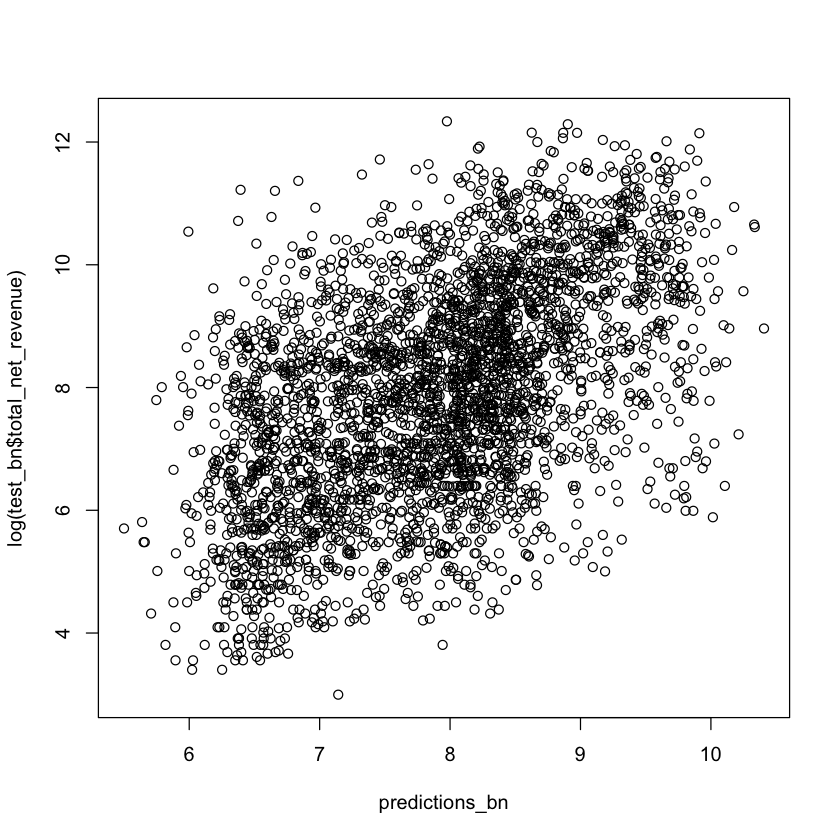

In [35]:


model_bn = lm(formula = log(total_net_revenue) ~ latitude + room_type + price_group + 
    availability_365 + price_group + `1 bedroom` + `2 bedroom` + 
    `park slope` + room + private + bedroom + brooklyn + apartment + 
    manhattan + spacious + sunny + bushwick + home + apt + bed + 
    williamsburg + close + nyc + bright + subway + quiet + heights + 
    heart + new + loft + bedstuy + length, data = train_bn)

model_m = lm(formula = log(total_net_revenue) ~ latitude + room_type + 
    calculated_host_listings_count + availability_365 + price_group + 
    `central park` + `2 bedroom` + `private bedroom` + `bedroom apartment` + 
    `upper east` + `1 br` + `cozy private` + `private bathroom` + 
    room + private + bedroom + cozy + apartment + spacious + 
    near + large + close + clean + bright + subway + quiet + 
    heights + shared + heart + new + loft + comfortable + location + 
    length, data = train_m)


summary(model_bn)

predictions_bn = predict(model_bn, test_bn)


RMSE = function(m, o){
  sqrt(mean((m - o)^2))
}

RMSE(exp(1)^predictions_bn, exp(1)^log(test_bn$total_net_revenue))
plot(predictions_bn, log(test_bn$total_net_revenue))



OK - so we have an *Adjusted R-Squared of **0.283.***, and an RMSE of 21k. So the model is off by about 21k USD / prediction on average.

Due to the lack of impactful factors, I think we would not want to use this model as a predictive tool. It is *not* very accurate.

However, I think this model would be useful in creating a listing by examining the variables within it.




Joining, by = "r_nm"



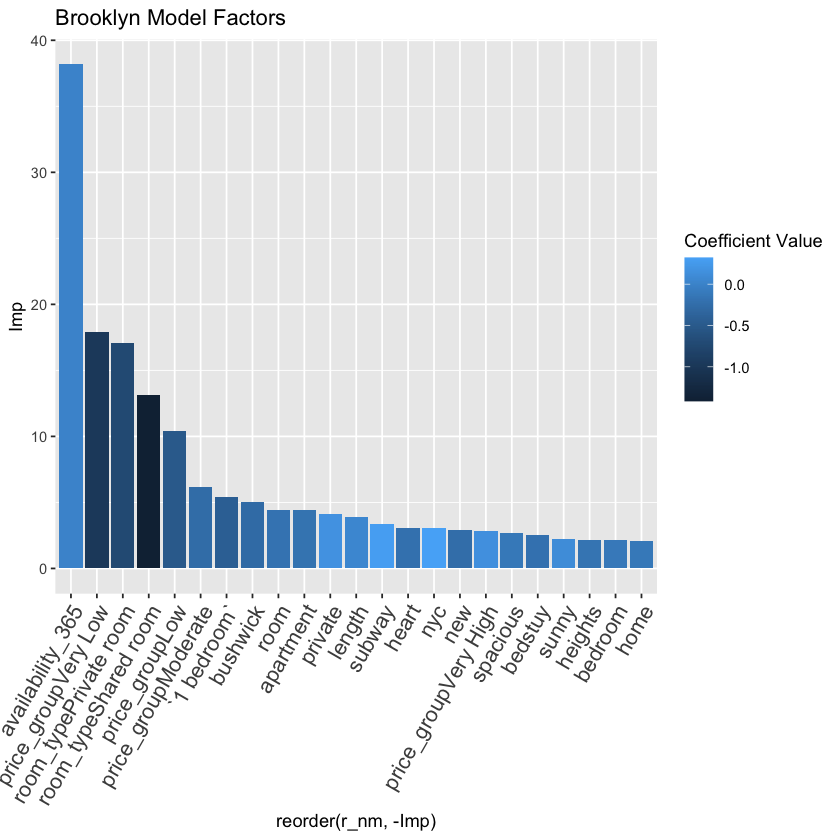

In [36]:
lmImp <- varImp(model_bn, scale = FALSE)
r_nm<-rownames(data.frame(lmImp))
Imp <- data.frame(lmImp)[,1]
df_imp <- data.frame(r_nm,Imp)
df_imp <- df_imp[order(Imp),]
df_type = data.frame(names(model_bn$coefficients),as.vector(model_bn$coefficients))

colnames(df_type) = c("r_nm","Coefficient Value")

df_new = df_imp %>% inner_join(df_type)



ggplot(subset(df_new, Imp > 2 & `Coefficient Value` < 4), aes(x = reorder(r_nm, -Imp), y = Imp, fill=`Coefficient Value`)) + 
  geom_bar(stat = "identity")+ theme(axis.text.x = element_text(angle = 60, hjust = 1, size = 13))+ggtitle("Brooklyn Model Factors")

Joining, by = "r_nm"



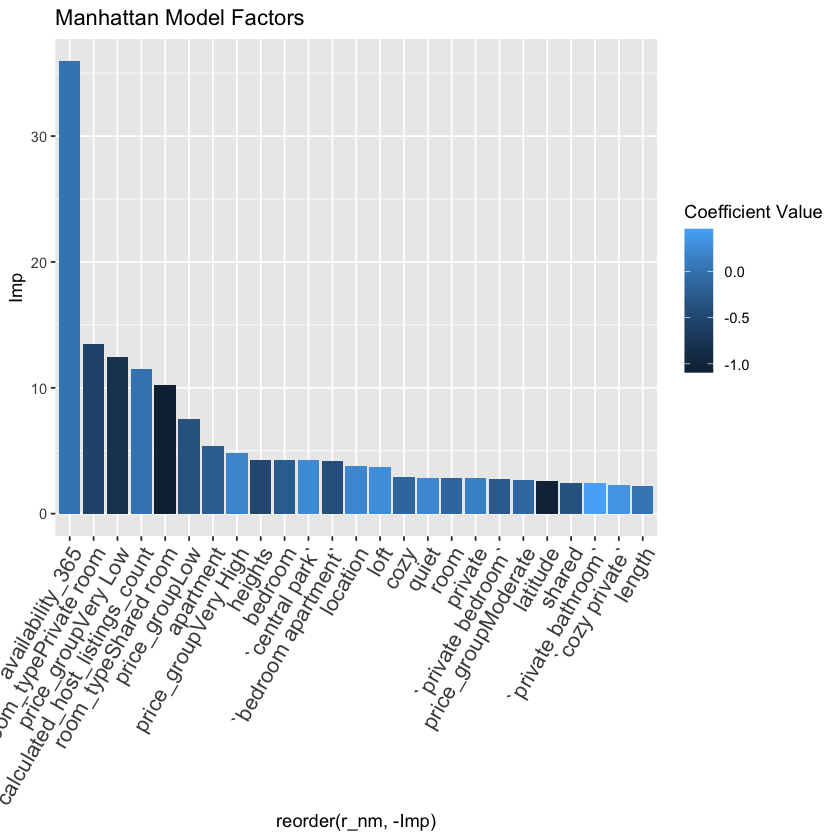

In [37]:
lmImp <- varImp(model_m, scale = FALSE)
r_nm<-rownames(data.frame(lmImp))
Imp <- data.frame(lmImp)[,1]
df_imp <- data.frame(r_nm,Imp)
df_imp <- df_imp[order(Imp),]
df_type = data.frame(names(model_m$coefficients),as.vector(model_m$coefficients))

colnames(df_type) = c("r_nm","Coefficient Value")

df_new = df_imp %>% inner_join(df_type)



ggplot(subset(df_new, Imp > 2 & `Coefficient Value` < 4), aes(x = reorder(r_nm, -Imp), y = Imp, fill=`Coefficient Value`)) + 
  geom_bar(stat = "identity")+ theme(axis.text.x = element_text(angle = 60, hjust = 1, size = 13)) + ggtitle("Manhattan Model Factors")

# Conclusion

I think there are some pretty cool takeaways here.

The text that you put in your Airbnb **DOES** matter, and it varies across what region you are located in. It is important to include specific text, espcially if your property contains it.

*I.E.* - if you're near **Central Park** - put that in the title! (Referencing above)

The most impactful factors we are missing - **REVIEW RATINGS**

If you're a high rated lister, and your property is also highly rated, you are most likely going to succeed in obtaining a larger net revenue!